# Calculate IRR

## Get filename

In [57]:
annotations_fn = '../data/annotations.tsv'

## Load and process annotations

In [58]:
# Some values are delineated as important (related to ethical principles or user rights) based on prior literature, as discussed in main paper.
important_values = [
    'Interpretable (to users)',
    'Beneficence',
    'Deferral to humans',
    'Privacy',
    'User influence',
    'Non-maleficence',
    'Explicability',
    'Respect for Law and public interest',
    'Not socially biased',
    'Fairness',
    'Critiqability',
    'Justice',
    'Respect for Persons',
    'Autonomy (power to decide)',
    'Transparent (to users)',
    'Collective influence'
]

# Value hierarchy. Some subvalues indicate an overarching value, as presented in paper Appendix C.
value_to_subvalues = {
 'Performance':           ['Accuracy', 'State-of-the-art'],
 'Building on past work': ['Building on classic work', 'Building on recent work'],
 'Generalization':        ['Avoiding train/test discrepancy', 'Flexibility/Extensibility'],
 'Efficiency':            ['Data efficiency','Energy efficiency','Label efficiency (reduced need for labeled data)',
                           'Low cost','Memory efficiency','Reduced training time', 'Fast'],
}

# Some columns were not useful for the below analysis so were deleted, for easier viewing and handling of the dataframes in this notebook.
irrelevant_columns = ['Year', 'Venue   ', '# Annotations', 'Reviewed for agreement', 'Comments', 'URL', 'Kind of task', 'Note   ', 
                      'Unnamed: 13', 'Unnamed: 97', 'Unnamed: 98']

In [59]:
!export PYTHONPATH=..
import pandas as pd
import numpy as np
import plotly.express as px

# get annotations
annotations = pd.read_csv(annotations_fn, sep='\t').dropna(how='all', axis='columns')  # drop empty colums
# rename columns
value_start_col = list(annotations.columns).index('Value Totals')  
value_series = annotations.iloc[1, value_start_col:]
value_cols = value_series.index.tolist()  # current col names
values = value_series.values.tolist()  # correct col names
annotations = annotations.rename(dict(zip(value_cols, values)), axis=1)  # fix col names
annotations = annotations.rename({'Annotators 1 and 2': 'Annotator'}, axis=1)
# drop irrelevant columns and value to drop 
def drop_if_exists(df, cols):
    for col in cols:
        if col in df.columns:
            df = df.drop(columns=[col])
    return df.reset_index(drop=True)
annotations = drop_if_exists(annotations, irrelevant_columns + values_to_drop)  
values = list(set(values) - set(values_to_drop))
# drop empty rows
annotations = annotations[annotations.Title.notna()].reset_index(drop=True)  # drop empty rows
annotations = annotations[annotations.Complete.notna()].reset_index(drop=True)  # drop not done rows
# switch from counts to bools
for value in values:  
    annotations[value] = annotations[value].fillna(0).apply(lambda count: int(bool(int(count))))  # from str to count to boolean existance flag
# apply tree
def has_any_values(row, vals):
    real_vals = filter(lambda val: val in row.index, vals)
    return row[real_vals].any()
for value, subvalues in value_to_subvalues.items():
    annotations[value] = annotations.apply(lambda row: int(has_any_values(row, [value]+subvalues)), axis=1)
    annotations = annotations.drop(subvalues, axis=1)
    values = list(set([value]+values) - set(subvalues))
papers = list(annotations.Title.unique())
percents = [len(annotations[annotations[value]==1].Title.unique())*100/len(papers) for value in values]
annotations['Negative potential?'] = annotations['Negative potential?'].fillna(0).apply(int)
annotations['Justification score'] = annotations['Justification score'].apply(lambda i: max(int(i),1) - 1)  # we deleted one category
# get annotations that were doubly annotated (by two annotators)
for title in annotations.Title.unique():
    n_raters = len(annotations[annotations.Title == title])
    annotations.loc[annotations.Title == title, '# Annotations'] = n_raters
pairs_annotations = annotations.copy()[annotations['# Annotations'] == 2.0].drop(['# Annotations'], axis=1).reset_index(drop=True)
pairs_papers = list(pairs_annotations.Title.unique())
pairs_percents = [len(pairs_annotations[pairs_annotations[value]==1].Title.unique())*100/len(papers) for value in values]

## Analyze

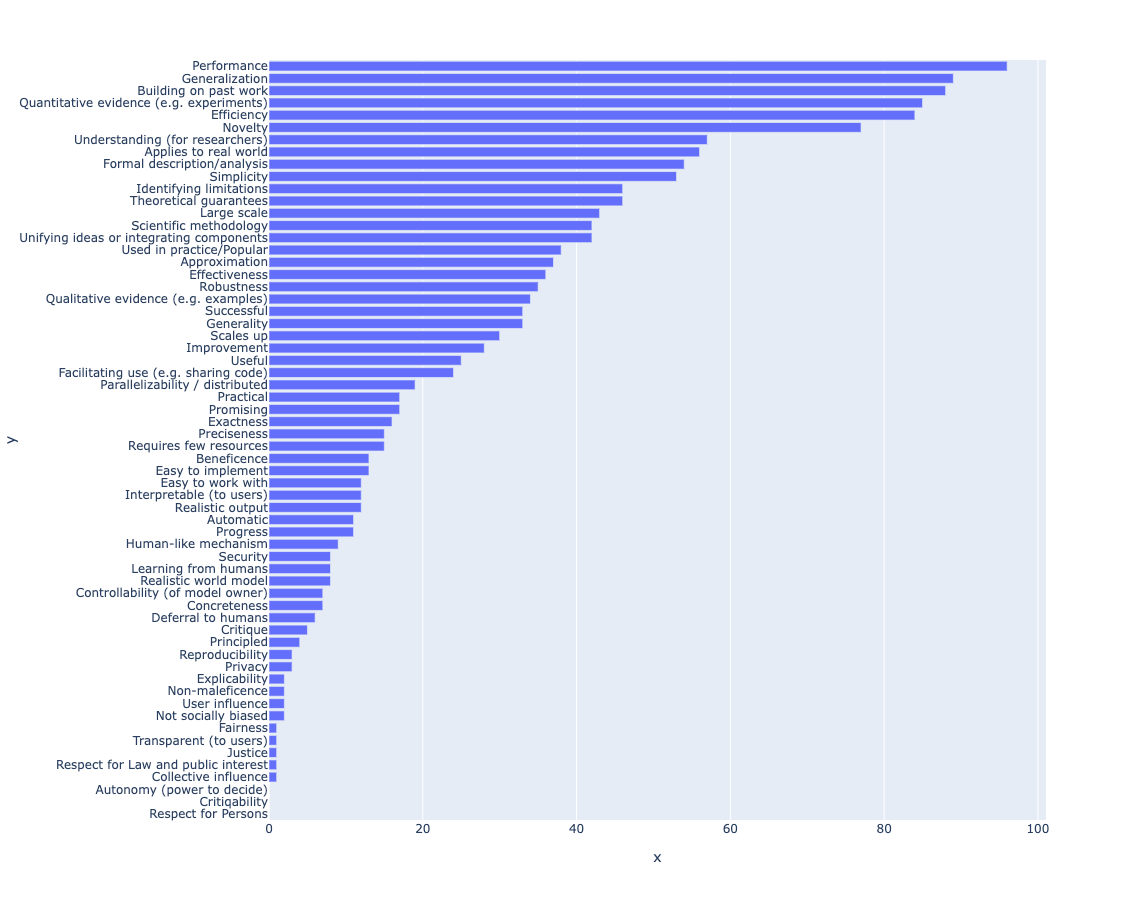

In [60]:
sorted_vals, sorted_percents = zip(*sorted(zip(values, percents), key=lambda t: t[1], reverse=True))
px.bar(y=sorted_vals[::-1], x=sorted_percents[::-1], orientation='h', width=600, height=900).update_layout(yaxis_tickvals=sorted_vals[::-1])

## IRR

In [62]:
# Agreement
n_matches = 0
for paper in pairs_papers:
    pair = pairs_annotations[pairs_annotations.Title == paper][values]
    n_matches += len(pair.sum()[pair.sum().isin([0,2])])
accuracy = n_matches * 100 / (len(values) * len(pairs_papers))
print(f'Agreement: {accuracy:0.1f}%')

Agreement: 87.0%


In [61]:
# Kendall's W
def value_counts_to_value_ranks(value_counts):
    value_ranks = dict()
    ties = []
    tie = []
    ordered_value_counts = sorted(value_counts, key=lambda value_count: value_count[1], reverse=True)
    for i, value_count in enumerate(ordered_value_counts):
        rank = i+1
        value, count = value_count
        next_value, next_count = ordered_value_counts[i+1] if (i < len(value_counts)-1) else (None, None)
        if tie == [] and count != next_count:  # singleton
            value_ranks[value] = rank
        elif count == next_count:  # start or part of tie
            tie.append((value, rank))
        elif tie != [] and count != next_count:  # end of tie
            tie.append((value, rank))
            tie_values, tie_ranks = zip(*tie)
            mean_rank = sum(tie_ranks)/len(tie_ranks)
            for value in tie_values:
                value_ranks[value] = mean_rank
            ties.append(tie)
            tie = []  # refresh
    return value_ranks, ties

def value_counts_to_value_ranks_simple(value_counts):
    ordered_value_counts = sorted(value_counts, key=lambda value_count: value_count[1], reverse=True)
    value_ranks = {value_count[0]:i+1 for i, value_count in enumerate(ordered_value_counts)}
    return value_ranks, []

annotators = annotations.Annotator.unique()
m = len(annotators)
k = len(values)
annotator_rankings = dict()
tie_correction = 0
for annotator in annotators:
    annotator_anns = annotations[annotations.Annotator == annotator]
    value_counts = list(dict(annotator_anns[values].sum()).items())
    value_ranks, ties = value_counts_to_value_ranks(value_counts)    
    tie_correction += sum([(len(tie)**3 - len(tie)) for tie in ties])
    annotator_rankings[annotator] = value_ranks
value_total_ranks = dict()
for value in values:
    value_total_ranks[value] = sum([ranking[value] for ranking in annotator_rankings.values()])
S_squared = sum([value_total_ranks[value]**2 for value in values])
A = 12. * S_squared
B = 3. * m**2 * k * (k+1)**2
C = (m**2 * (k**3 - k)) - (m * tie_correction)
W = (A - B)/C
print(f"Kendall's W: {W:.3}")

Kendall's W: 0.804
